# Model quantization investigations

[quantization.py](quantization.py) provides a few functions used in this notebook.

In [190]:
from quantization import get_array_size_in_bytes, dequantize_weights, dequantize_weights_per_layer
from model_quantization import load_model, quantize_model_per_layer
from shared import VALIDATION, DEVICE
import torch
from math import sqrt, ceil
import numpy as np
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
device = DEVICE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:
exp = 201 # Pick up a model to quantize
num_bits=16 # If you want to change the number of bits, you need to reload the model
# you can use 3 bits , it still works kind of correctly
model, dl_dict = load_model(exp)

Using augmentations ['h_roll', 'flip']
TOTAL ELEMENTS 7211
TOTAL ELEMENTS 2463
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_201.npy
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_202.npy


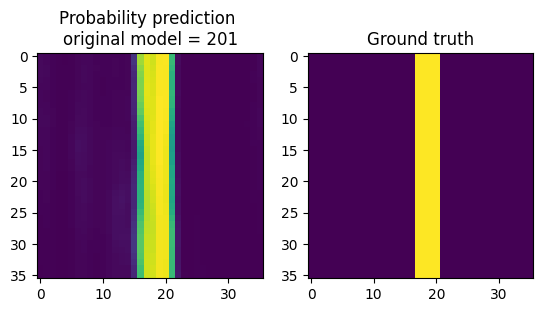

In [240]:
img, label = next(iter(dl_dict[VALIDATION]))
with torch.no_grad():
    output = model(img)
selected_index = 12 # image to pick from the first validation batch
plt.figsize = (10, 5)
plt.subplot(1, 2, 1)
plt.imshow(torch.sigmoid(output[selected_index, 0, ...]).detach().cpu().numpy())
plt.title(f'Probability prediction \noriginal model = {exp}')
plt.subplot(1, 2, 2)
plt.title("Ground truth")
plt.imshow(label[selected_index, 0, ...].detach().cpu().numpy().astype(float))
plt.show()

In [241]:
params = torch.cat([p.flatten() for p in model.parameters() if p.requires_grad])
params = params.detach().cpu().numpy()
print(len(params), "=", model.count_parameters(), "->", get_array_size_in_bytes(params), "Bytes")
quantized_weights, quantization_parameters = quantize_model_per_layer(model, num_bits=num_bits)


7.26 Mb
1904135 = 1904135 -> 7616540 Bytes
3.63 Mb
7.26 Mb
compression ratio = 2.002


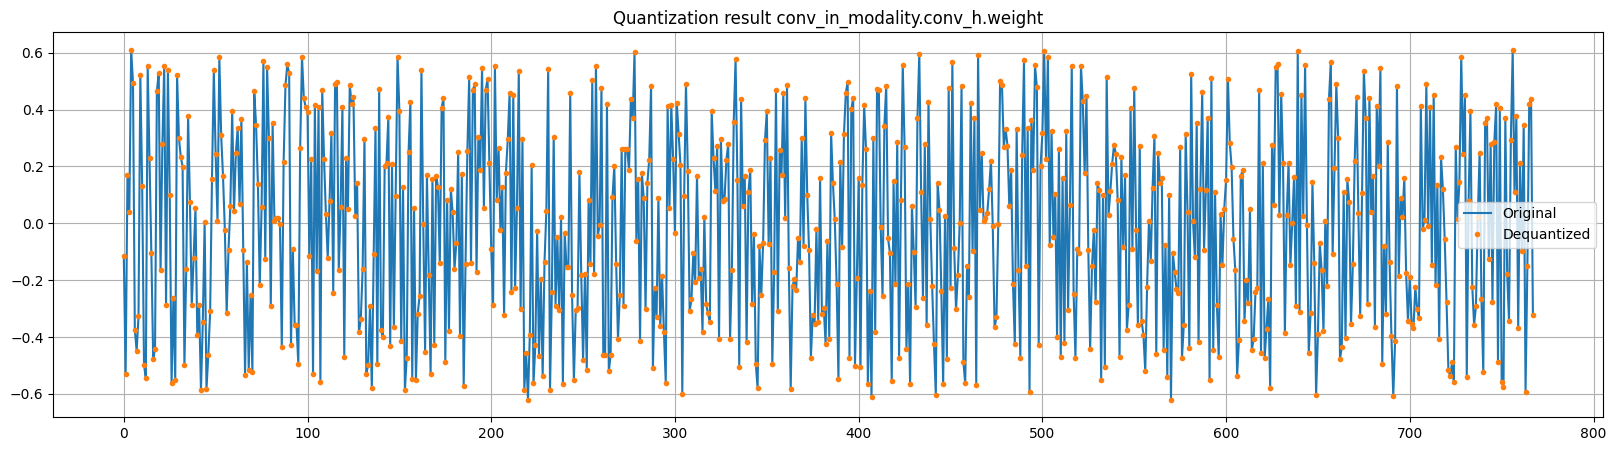

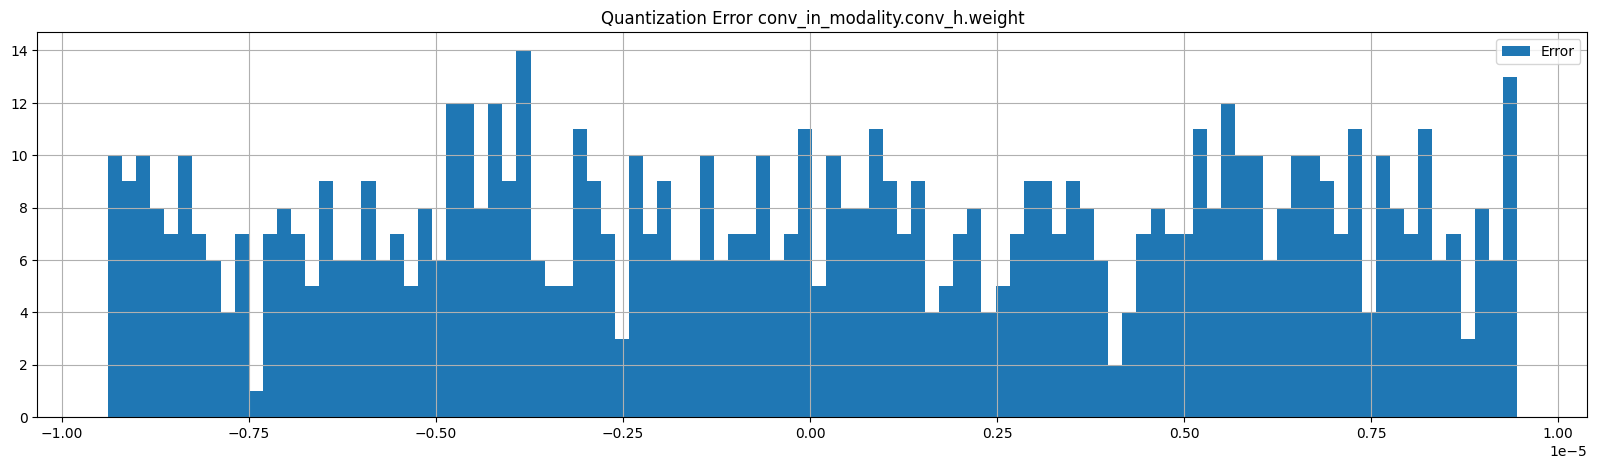

In [242]:
params_dequant = dequantize_weights_per_layer(quantized_weights, quantization_parameters)
layer_key= "conv_in_modality.conv_h.weight"
model_params_dict = dict(model.named_parameters())
params_no_qant = model_params_dict[layer_key].flatten().detach().cpu().numpy()
plt.figure(figsize=(20,5))
plt.plot(params_no_qant, label="Original")
plt.plot(params_dequant[layer_key].flatten(), ".", label="Dequantized")
plt.legend()
plt.grid()
plt.title(f"Quantization result {layer_key}")
plt.show()
plt.figure(figsize=(20,5))
plt.hist(params_no_qant-params_dequant[layer_key].flatten(), bins=100, label="Error")
plt.legend()
plt.title(f"Quantization Error {layer_key}")
plt.grid()
plt.show()

In [243]:
# Reinject dequantized weights into the model
for name, param in model.named_parameters():
    if name in params_dequant:
        param.data = torch.nn.Parameter(torch.from_numpy(params_dequant[name])).to(device=device)
        print(name, "has been updated with quantized weights")

conv_in_modality.conv_h.weight has been updated with quantized weights
conv_in_modality.conv_v.weight has been updated with quantized weights
conv_stack.0.conv_h.weight has been updated with quantized weights
conv_stack.0.conv_v.weight has been updated with quantized weights
conv_stack.1.conv_h.weight has been updated with quantized weights
conv_stack.1.conv_v.weight has been updated with quantized weights
conv_stack.2.conv_h.weight has been updated with quantized weights
conv_stack.2.conv_v.weight has been updated with quantized weights
conv_out_modality.conv_h.weight has been updated with quantized weights
conv_out_modality.conv_v.weight has been updated with quantized weights


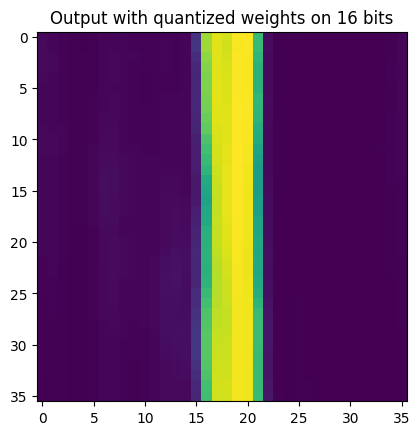

In [244]:
with torch.no_grad():
    output_with_qant = model(img)
plt.imshow(torch.sigmoid(output_with_qant[selected_index, 0, ...]).detach().cpu().numpy())
plt.title(f"Output with quantized weights on {num_bits} bits")
plt.show()

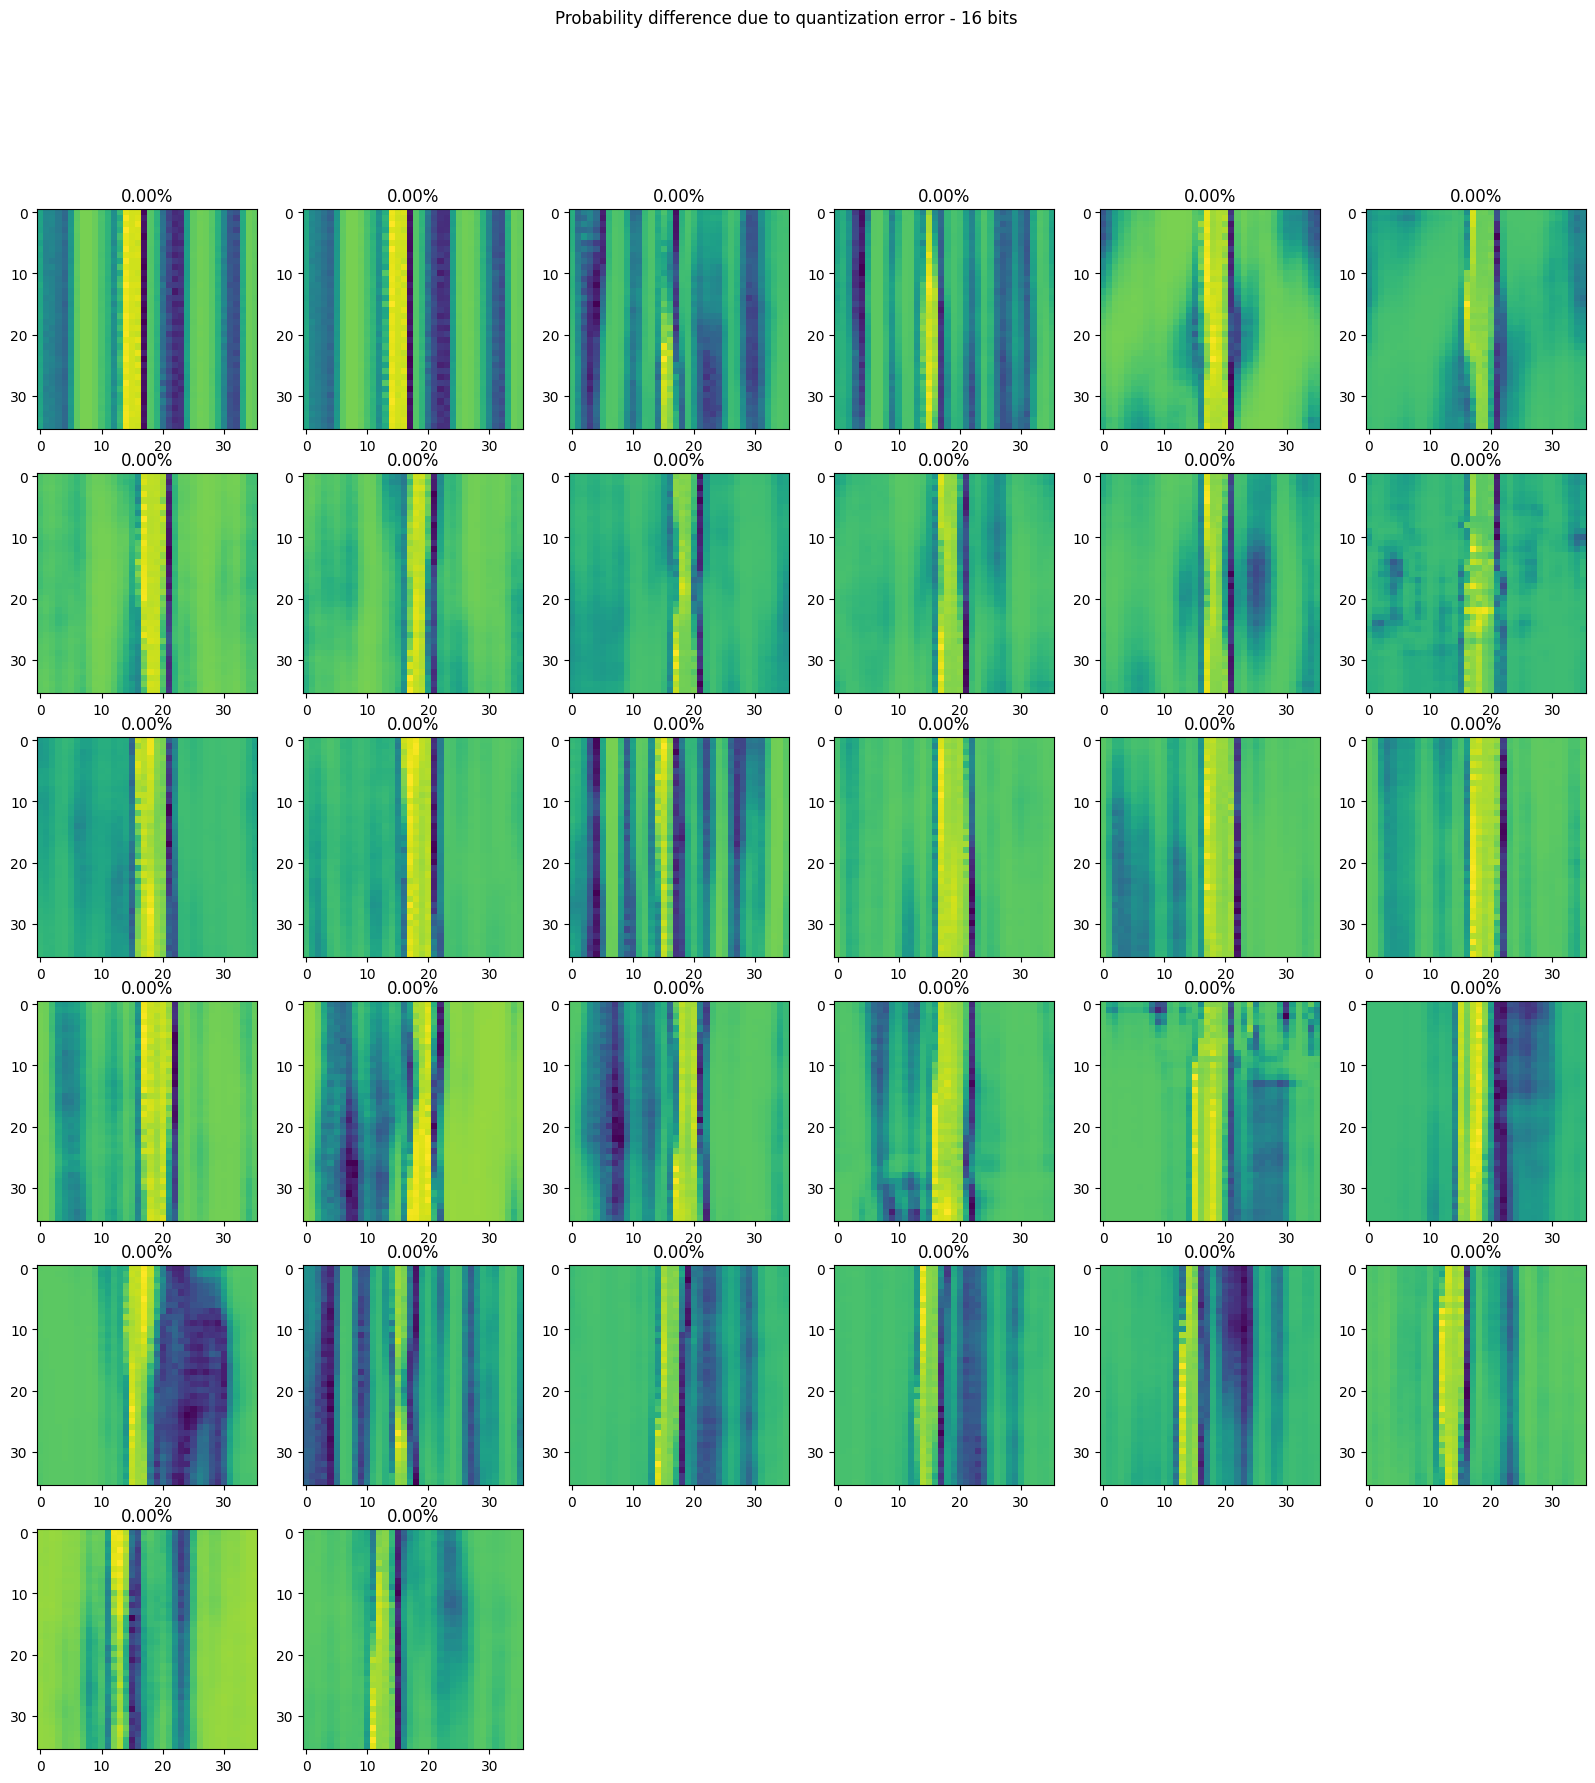

In [245]:

error = torch.sigmoid(output_with_qant)-torch.sigmoid(output)
error = error[:, 0, ...].detach().cpu().numpy()
plt.figure(figsize=(20, 20))
n = int(sqrt(error.shape[0])+0.5)
for idx in range(error.shape[0]):
    plt.subplot(n, ceil(error.shape[0]/n), idx+1)
    plt.title(f"{np.abs(error)[idx].mean():.2%}")
    plt.imshow(error[idx])
plt.suptitle(f"Probability difference due to quantization error - {num_bits} bits")
plt.show()

In [246]:
dataloader = dl_dict[VALIDATION]
from metrics import compute_metrics
from tqdm import tqdm
from shared import (
    ACCURACY, PRECISION, RECALL, F1_SCORE, IOU,
)
current_metrics = {
    ACCURACY: 0.,
    PRECISION: 0.,
    RECALL: 0.,
    F1_SCORE: 0.,
    IOU: 0.
}
for img, label in tqdm(dataloader):
    with torch.no_grad():
        output = model(img)
        metrics_on_batch = compute_metrics(output, label)
        for k, v in metrics_on_batch.items():
            current_metrics[k] += v
for k, v in metrics_on_batch.items():
    current_metrics[k] /= (len(dataloader))
    current_metrics[k] = current_metrics[k].item()
current_metrics

100%|██████████| 77/77 [00:10<00:00,  7.56it/s]


{'accuracy': 0.9683681130409241,
 'precision': 0.7998725771903992,
 'recall': 0.8879573941230774,
 'dice': 0.8370987772941589,
 'iou': 0.7247614860534668}

In [ ]:
# Not quantized model
print("not quantized model")
current_metrics

not quantized model


{'accuracy': 0.9683680534362793,
 'precision': 0.7998656034469604,
 'recall': 0.8879660964012146,
 'dice': 0.8370986580848694,
 'iou': 0.7247620820999146}

# Global weights distribution

In [213]:
model, dl_dict = load_model(exp) # Reload model before doing anything stupid and visualize quantized weights

Using augmentations ['h_roll', 'flip']
TOTAL ELEMENTS 7211
TOTAL ELEMENTS 2463
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_201.npy
Got NaN in image /Data/geosciences/TP_5/data/validation/images/well_15_patch_202.npy


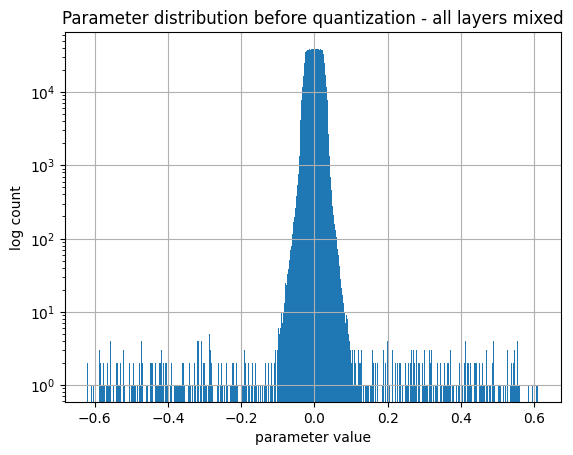

In [193]:
plt.hist(params, bins=1000)
plt.yscale('log')
plt.ylabel('log count')
plt.xlabel('parameter value')
plt.grid()
plt.title('Parameter distribution before quantization - all layers mixed')
plt.show()


# Need  for per-layer quantization
The following graph shows that if we perform global model quantization (same scaling for all weights, we will loose a lot of precision as each layer's weight have a slightly different dynamic).

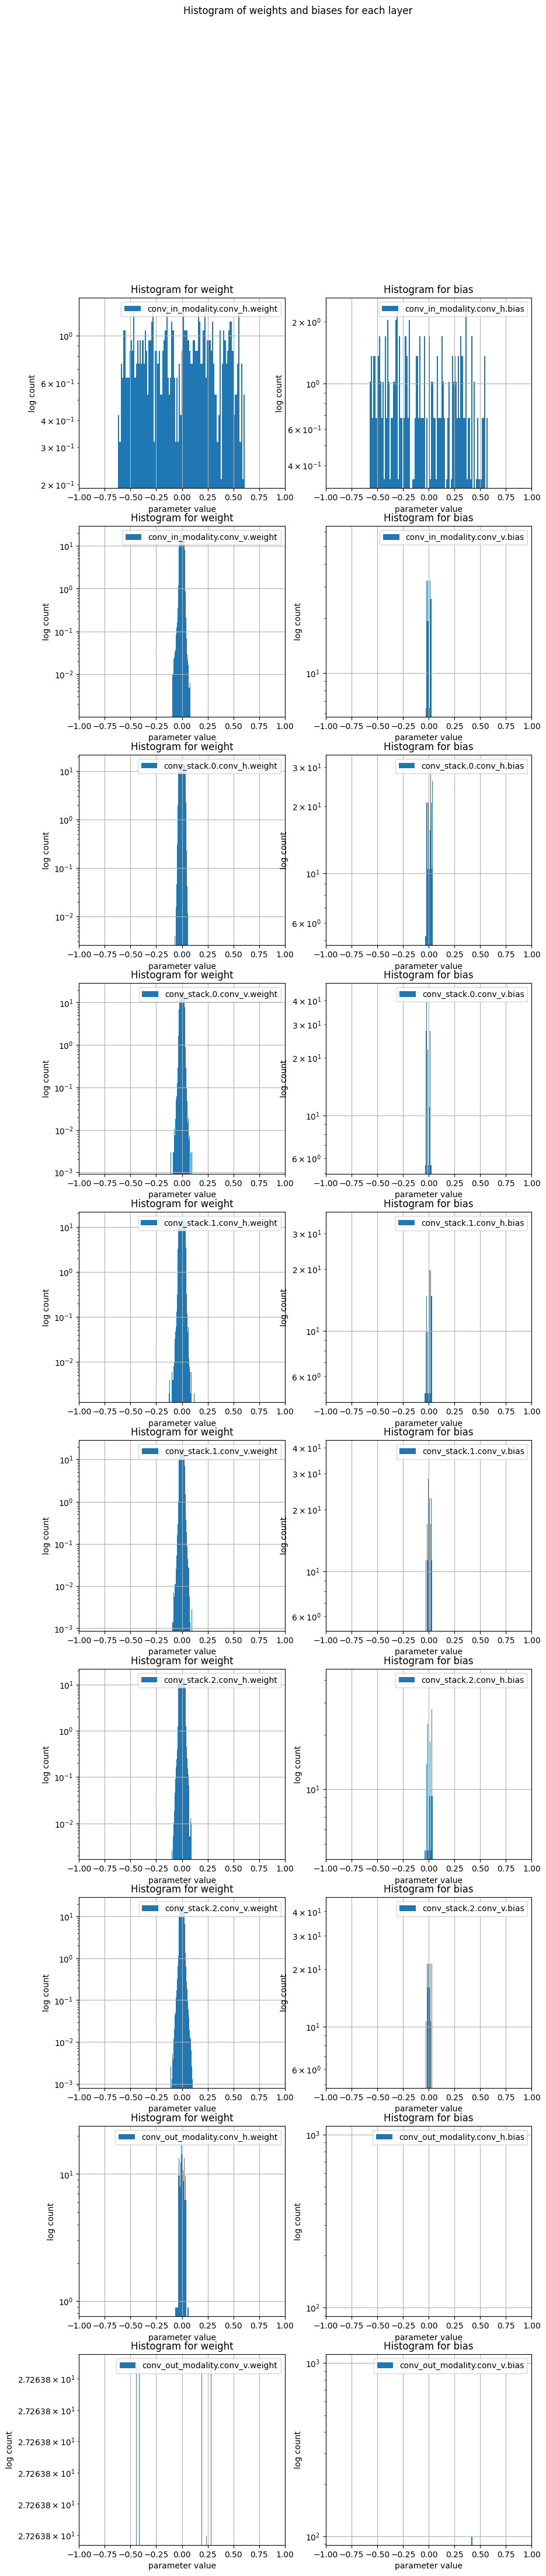

In [194]:
from matplotlib import pyplot as plt
tot = len([1 for _ in model.named_parameters()])
plt.figure(figsize=(10, tot//2*5))
for idx, (name, param) in enumerate(model.named_parameters()):
    if 'bias' not in name:
        plt.subplot(tot//2, 2, idx//2 * 2 + 1)
    else:
        plt.subplot(tot//2, 2, idx//2 * 2 + 2)
    if param.requires_grad:
        layer_params = param.detach().cpu().numpy().flatten()
        plt.hist(layer_params, bins=100, density=True, alpha=1, label=name)
        # plt.title(f'Histogram for Layer: {name}')
        plt.title('Histogram for weight' if 'weight' in name else 'Histogram for bias')
        plt.yscale('log')
        plt.ylabel('log count')
        plt.xlabel('parameter value')
        plt.legend()
        plt.xlim(-1., 1.)
        plt.grid()
plt.suptitle('Histogram of weights and biases for each layer')
plt.show()